# Tree Methods

Aim: Predict housing prices using a regression model.

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.tree import export_graphviz

In [25]:
def get_data(url: str) -> pd.DataFrame:
    df = pd.read_csv(url)
    return df

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    TODO:
    - choose cols: the cols in the instructions are the only cols in the dataset so no need to choose
    - fill nas with 0
    - log transform median house value
    - train-test-val split
    - dictvectorizer
    """
    # only one column has null values so this is fine
    df = df.fillna(0)
    df.median_house_value = np.log1p(df.median_house_value)
    return df

def train_test_val_split(df: pd.DataFrame) -> pd.DataFrame:
    train_df, combined_test_df = train_test_split(df, test_size=0.4, random_state=1)
    test_df, val_df = train_test_split(combined_test_df, test_size=0.5, random_state=1)
    return train_df, test_df, val_df

def prep_training_data(train_df: pd.DataFrame, test_df: pd.DataFrame, val_df: pd.DataFrame) -> pd.DataFrame:
    y_train = train_df.median_house_value
    y_test = test_df.median_house_value
    y_val = val_df.median_house_value

    # drop median house value from train_df
    train_df.drop('median_house_value', axis=1, inplace=True)
    test_df.drop('median_house_value', axis=1, inplace=True)
    val_df.drop('median_house_value', axis=1, inplace=True)

    return train_df, test_df, val_df, y_train, y_test, y_val

def one_hot_transform(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    One hot encodes the specified columns in the dataframe.

    Args:
        df (pd.DataFrame): dataframe to one hot encode
        cols (list[str]): list of columns to one hot encode

    Returns:
        pd.DataFrame: dataframe with specified columns one hot encoded
    """
    for col in cols:
        onehot = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
        onehot_encoded = onehot.fit_transform(df[col].values.reshape(-1, 1))
        df = pd.concat([df, onehot_encoded], axis=1).drop(f'{col}', axis=1)
    
    return df

def prepare_credit_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the credit data for training.

    Args:
        df (pd.DataFrame): dataframe to prepare

    Returns:
        pd.DataFrame: prepared dataframe
    """
    df.columns = df.columns.str.lower()
    df.status = df.status.map({1: 'ok', 2: 'default', 0: "unk"})

    home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

    df.home = df.home.map(home_values)

    marital_values = {
        1: 'single',
        2: 'married',
        3: 'widow',
        4: 'separated',
        5: 'divorced',
        0: 'unk'
    }

    df.marital = df.marital.map(marital_values)

    records_values = {
        1: 'no',
        2: 'yes',
        0: 'unk'
    }

    df.records = df.records.map(records_values)

    job_values = {
        1: 'fixed',
        2: 'partime',
        3: 'freelance',
        4: 'others',
        0: 'unk'
    }

    df.job = df.job.map(job_values)

    for c in ['income', 'assets', 'debt']:
        df[c] = df[c].replace(to_replace=99999999, value=np.nan)

    df = df[df.status != 'unk'].reset_index(drop=True)

    return df
 


In [26]:
data = get_data("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv")
data = prepare_credit_data(data)

df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

df_train = df_train.drop('status', axis=1)
df_val = df_val.drop('status', axis=1)
df_test = df_test.drop('status', axis=1)


In [27]:
# manual implementation of a decision tree algorithm 
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'
        
xi = df_train.iloc[0].to_dict()
print(xi)
print(assess_risk(xi))

{'seniority': 12, 'home': 'private', 'time': 24, 'age': 28, 'marital': 'married', 'records': 'no', 'job': 'fixed', 'expenses': 45, 'income': 102.0, 'assets': nan, 'debt': nan, 'amount': 700, 'price': 1229}
default


In [28]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_train

array([[2.80e+01, 7.00e+02, 0.00e+00, ..., 0.00e+00, 1.20e+01, 2.40e+01],
       [2.80e+01, 1.15e+03, 0.00e+00, ..., 0.00e+00, 4.00e+00, 6.00e+01],
       [2.70e+01, 1.95e+03, 6.00e+03, ..., 0.00e+00, 0.00e+00, 6.00e+01],
       ...,
       [3.20e+01, 1.49e+03, 0.00e+00, ..., 1.00e+00, 9.00e+00, 6.00e+01],
       [2.10e+01, 1.40e+03, 3.00e+03, ..., 0.00e+00, 0.00e+00, 6.00e+01],
       [2.60e+01, 1.40e+03, 0.00e+00, ..., 0.00e+00, 8.00e+00, 6.00e+01]])

In [29]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [31]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:, 1]

In [32]:
roc_auc_score(y_val, y_pred)

0.6446776328228399

In [63]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
val_y_pred = dt.predict_proba(X_val)[:, 1]
train_y_pred = dt.predict_proba(X_train)[:, 1]
val_auc = roc_auc_score(y_val, val_y_pred)

train_auc = roc_auc_score(y_train, train_y_pred)

print(f"train: {train_auc}")
print(f"val: {val_auc}")

train: 0.7769739797926325
val: 0.7519852524106636


[Text(0.5, 0.875, 'income <= 89.5\ngini = 0.402\nsamples = 2672\nvalue = [1927, 745]'),
 Text(0.25, 0.625, 'seniority <= 2.5\ngini = 0.5\nsamples = 781\nvalue = [400, 381]'),
 Text(0.125, 0.375, 'records=no <= 0.5\ngini = 0.463\nsamples = 347\nvalue = [126, 221]'),
 Text(0.0625, 0.125, 'gini = 0.245\nsamples = 70\nvalue = [10, 60]'),
 Text(0.1875, 0.125, 'gini = 0.487\nsamples = 277\nvalue = [116, 161]'),
 Text(0.375, 0.375, 'records=no <= 0.5\ngini = 0.466\nsamples = 434\nvalue = [274, 160]'),
 Text(0.3125, 0.125, 'gini = 0.456\nsamples = 88\nvalue = [31, 57]'),
 Text(0.4375, 0.125, 'gini = 0.418\nsamples = 346\nvalue = [243, 103]'),
 Text(0.75, 0.625, 'records=yes <= 0.5\ngini = 0.311\nsamples = 1891\nvalue = [1527, 364]'),
 Text(0.625, 0.375, 'job=partime <= 0.5\ngini = 0.239\nsamples = 1565\nvalue = [1348, 217]'),
 Text(0.5625, 0.125, 'gini = 0.196\nsamples = 1447\nvalue = [1288, 159]'),
 Text(0.6875, 0.125, 'gini = 0.5\nsamples = 118\nvalue = [60, 58]'),
 Text(0.875, 0.375, 'senio

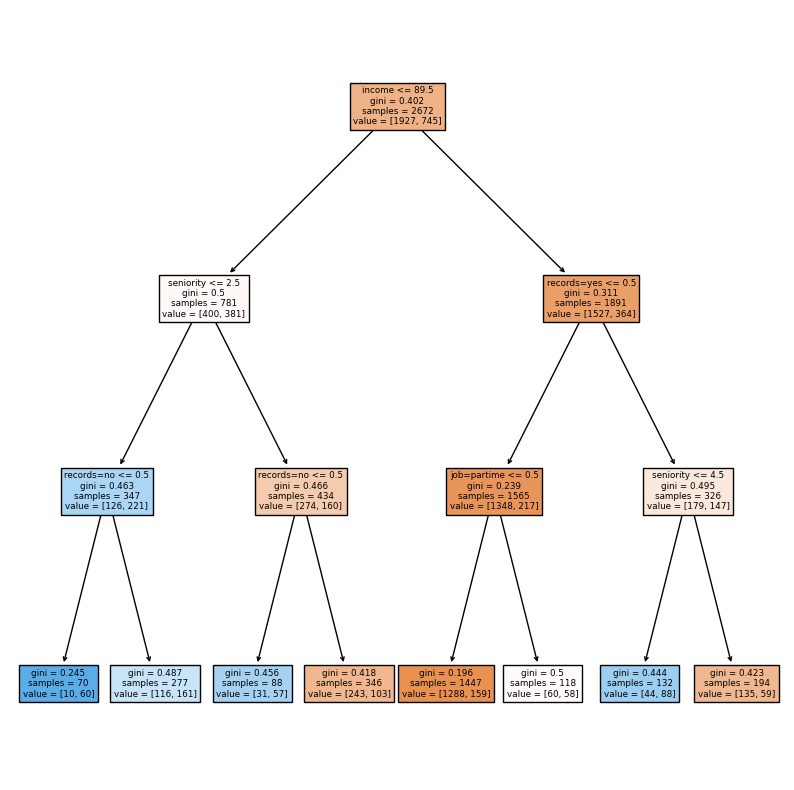

In [67]:
# plot decision tree
plt.figure(figsize=(10, 10))
plot_tree(dt, feature_names=dv.get_feature_names_out(), filled=True)

## Homework

In [4]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

df = clean_data(get_data(url))

df = one_hot_transform(df, ['ocean_proximity'])

train_df, test_df, val_df = train_test_val_split(df)


train_df, test_df, val_df, y_train, y_test, y_val = prep_training_data(train_df, test_df, val_df)

In [5]:
clf = tree.DecisionTreeRegressor(max_depth=1)
clf = clf.fit(train_df, y_train)
y_preds = clf.predict(test_df)


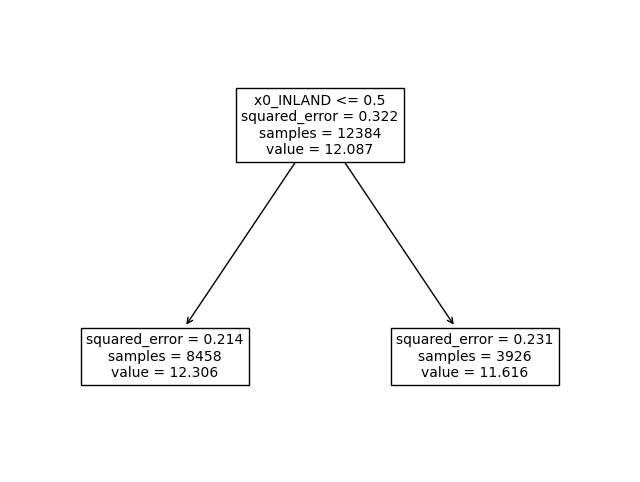

In [6]:
_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(clf, ax=ax, feature_names=train_df.columns, fontsize=10)

In [7]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rfr = rfr.fit(train_df, y_train)
y_preds = rfr.predict(test_df)


In [8]:
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print(f'RMSE: {rmse}')

RMSE: 0.24945577690249893


In [9]:
def random_forest_regressor(train_df: pd.DataFrame, test_df: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame) -> None:
    """
    Trains a random forest regressor on the training data and prints the RMSE on the test data.

    Args:
        train_df (pd.DataFrame): training data
        test_df (pd.DataFrame): test data
        y_train (pd.DataFrame): training labels
        y_test (pd.DataFrame): test labels
    """
    max_depth = [10, 15, 20, 25]

    for i in max_depth:
        rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1, max_depth=i)
        rfr = rfr.fit(train_df, y_train)
        y_preds = rfr.predict(test_df)
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        print(f'RMSE: {rmse}')
    

    # n_estimators = list(range(10, 201, 10))
    # for i in n_estimators:
    #     rfr = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=1)
    #     rfr = rfr.fit(train_df, y_train)
    #     y_preds = rfr.predict(test_df)
    #     rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    #     print(f'RMSE: {rmse}')

random_forest_regressor(train_df, test_df, y_train, y_test)

RMSE: 0.2584129317977883
RMSE: 0.24940402451392435
RMSE: 0.2500409275224987
RMSE: 0.25008289179037685


In [10]:
def random_forest_regressor(train_df: pd.DataFrame, test_df: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame) -> None:
    """
    Trains a random forest regressor on the training data and prints the RMSE on the test data.

    Args:
        train_df (pd.DataFrame): training data
        test_df (pd.DataFrame): test data
        y_train (pd.DataFrame): training labels
        y_test (pd.DataFrame): test labels
    """

    rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1, max_depth=20)
    rfr = rfr.fit(train_df, y_train)
    y_preds = rfr.predict(test_df)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'RMSE: {rmse}')
    return rfr
    

    # n_estimators = list(range(10, 201, 10))
    # for i in n_estimators:
    #     rfr = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=1)
    #     rfr = rfr.fit(train_df, y_train)
    #     y_preds = rfr.predict(test_df)
    #     rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    #     print(f'RMSE: {rmse}')

rfr = random_forest_regressor(train_df, test_df, y_train, y_test)

RMSE: 0.2500409275224987


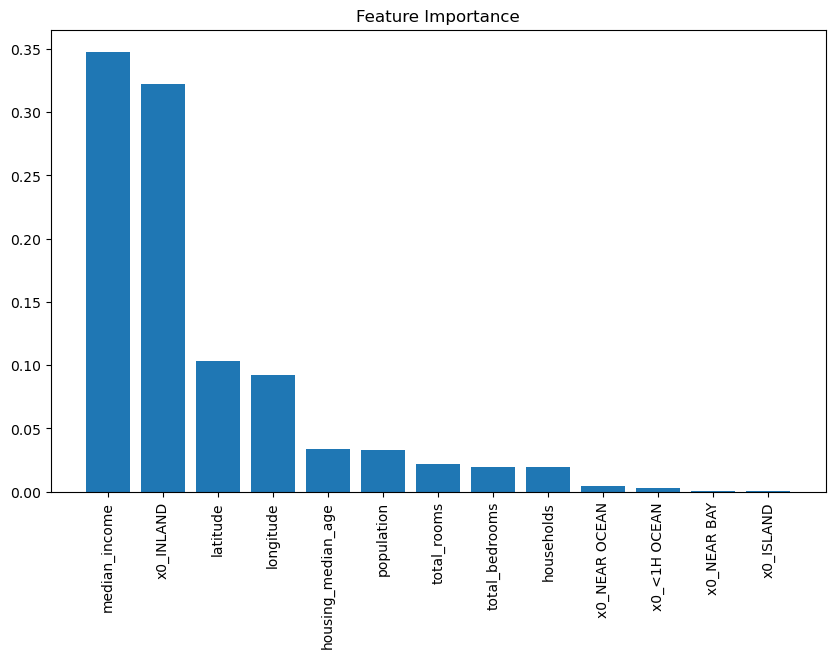

In [11]:
rfr.feature_importances_

def plot_feature_importances(rfr: RandomForestRegressor, train_df: pd.DataFrame) -> None:
    """
    Plots the feature importances of a random forest regressor.

    Args:
        rfr (RandomForestRegressor): random forest regressor
        train_df (pd.DataFrame): training data
    """
    importances = rfr.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [train_df.columns[i] for i in indices]
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(train_df
        .shape[1]), importances[indices])
    plt.xticks(range(train_df.shape[1]), names, rotation=90)
    plt.show()

plot_feature_importances(rfr, train_df)
